In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://raw.githubusercontent.com/vlawhern/arl-eegmodels/master/EEGModels.py

--2022-02-22 05:27:11--  https://raw.githubusercontent.com/vlawhern/arl-eegmodels/master/EEGModels.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18033 (18K) [text/plain]
Saving to: ‘EEGModels.py’

EEGModels.py        100%[===================>]  17.61K  --.-KB/s    in 0.001s  

2022-02-22 05:27:11 (18.9 MB/s) - ‘EEGModels.py’ saved [18033/18033]



In [ ]:
!pip install pyriemann
!pip install mne

     |████████████████████████████████| 42 kB 1.0 MB/s 
  Created wheel for pyriemann: filename=pyriemann-0.2.7-py2.py3-none-any.whl size=49770 sha256=4f72dd73793f94640e2b66f7510e28b5a63030ec31e2ed39bf9c8337c16709fb
  Stored in directory: /root/.cache/pip/wheels/5c/b7/55/27dcb08ed8fb58da8c1be108c23928ffb9125c9c1da2ddfb53
Successfully built pyriemann
     |████████████████████████████████| 7.4 MB 8.1 MB/s 


In [ ]:
!wget https://raw.githubusercontent.com/ProPranu6/meg-eegnet-predictions-and-analysis/spotlight/meg_pred_analysis.py

--2022-02-22 05:29:04--  https://raw.githubusercontent.com/ProPranu6/meg-eegnet-predictions-and-analysis/spotlight/meg_pred_analysis.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18328 (18K) [text/plain]
Saving to: ‘meg_pred_analysis.py’

meg_pred_analysis.p 100%[===================>]  17.90K  --.-KB/s    in 0.001s  

2022-02-22 05:29:04 (27.4 MB/s) - ‘meg_pred_analysis.py’ saved [18328/18328]



In [ ]:
import meg_pred_analysis
from tensorflow.keras.utils import plot_model
import numpy as np
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.preprocessing import OneHotEncoder as OH



In [ ]:
from meg_pred_analysis import EEGNet, ModelCheckpoint, evaluate_model, generate_confusion_matrix, visualise_results, visualise_results_acr, tsne_visualise, ml_diff_verdict, plot_diff_cols, get_subject_data

### **[Kaggle Visualising-The-Imagining-Brain Dataset](https://www.kaggle.com/emanuele/visual-imagination-with-meg)**

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 306, 1500, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 306, 1500, 8)      256       
                                                                 
 batch_normalization (BatchN  (None, 306, 1500, 8)     32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 1500, 16)      4896      
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 1500, 16)      64        
 hNormalization)                                                 
                                                             

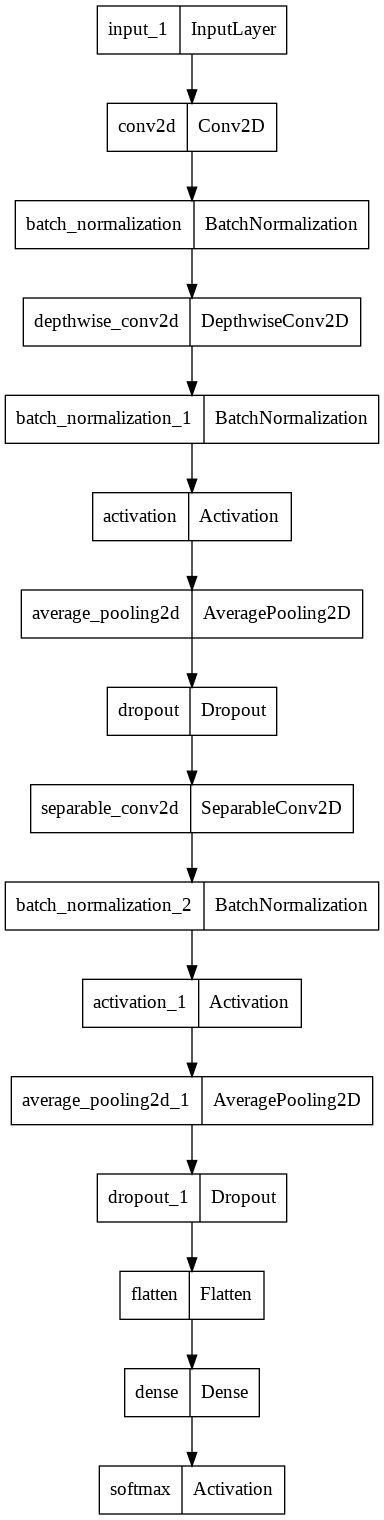

In [ ]:
model = EEGNet(nb_classes=2, Chans=306, Samples=1500, dropoutRate=0.5, kernLength=32, F1=8, D=2,  F2=16, norm_rate=0.25, dropoutType='Dropout')
model.summary()
plot_model(model)

In [ ]:
def get_subject_data(subject_numbers=[1], mod=False, print_info=True, scale=False):
  global oe
  for i, sn in enumerate(subject_numbers):

    data = np.load(f"/content/drive/MyDrive/MEG-Visualising-The-Imagining-Brain/{sn}.npz")
    vals = list(data.values())

    change_format = lambda x: np.expand_dims(x, axis=-1)
    le = LE()
    oe = OH(sparse=False)
    change_encoding = lambda x: oe.fit_transform(x)

    vals[0] = change_format(vals[0]*(1e12 if scale else 1))
    vals[1] = change_format(vals[1])

    if i == 0:
      feat = vals[0]
      lab = vals[1]
    else:
      feat = np.concatenate([vals[0], feat_prev])
      lab = np.concatenate([vals[1], lab_prev])

    feat_prev = feat
    lab_prev = lab

  tr_te_rat = 0.8
  tr_val_rat = 0.8

  xtrain, xtest, ytrain, ytest = meg_pred_analysis.train_test_split(feat, lab, train_size=tr_te_rat, stratify=lab)
  xtrain, xvalidate, ytrain, yvalidate = meg_pred_analysis.train_test_split(xtrain, ytrain, train_size=tr_val_rat, stratify=ytrain)

  xtrain, xvalidate, xtest = xtrain/np.linalg.norm(xtrain, axis=0, keepdims=True), xvalidate/np.linalg.norm(xvalidate, axis=0, keepdims=True), xtest/np.linalg.norm(xtest, axis=0, keepdims=True)
  ytrain, yvalidate, ytest = change_encoding(ytrain), change_encoding(yvalidate), change_encoding(ytest)

  if print_info:
    print('xtrain shape:', xtrain.shape)
    print('xvalidate shape:', xvalidate.shape)
    print('xtest shape:', xtest.shape)
    print(xtrain.shape[0], 'train samples')
    print(xvalidate.shape[0], 'validate samples')
    print(xtest.shape[0], 'test samples')

  return xtrain, xvalidate, xtest, ytrain, yvalidate, ytest





In [ ]:
#overwriting the "get_subject_data" function in "meg_pred_analysis" module
import sys
module = sys.modules['meg_pred_analysis']
module.get_subject_data = get_subject_data
sys.modules['meg_pred_analysis'] = module

In [ ]:
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = get_subject_data([1, 2], scale=False) #Data comes in here ---get_subject_data(versions[v], mod=True)


xtrain shape: (237, 306, 1500, 1)
xvalidate shape: (60, 306, 1500, 1)
xtest shape: (75, 306, 1500, 1)
237 train samples
60 validate samples
75 test samples


In [ ]:
(X_train/np.linalg.norm(X_train, axis=0, keepdims=True)).shape

(114, 306, 1500, 1)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.69274, saving model to /tmp/checkpoint.h5
15/15 - 11s - loss: 0.6960 - accuracy: 0.5148 - val_loss: 0.6927 - val_accuracy: 0.5167 - 11s/epoch - 717ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.69274 to 0.69265, saving model to /tmp/checkpoint.h5
15/15 - 1s - loss: 0.6657 - accuracy: 0.6034 - val_loss: 0.6927 - val_accuracy: 0.5167 - 944ms/epoch - 63ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.69265 to 0.69225, saving model to /tmp/checkpoint.h5
15/15 - 1s - loss: 0.6583 - accuracy: 0.6414 - val_loss: 0.6923 - val_accuracy: 0.5167 - 942ms/epoch - 63ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.69225 to 0.69171, saving model to /tmp/checkpoint.h5
15/15 - 1s - loss: 0.6218 - accuracy: 0.7089 - val_loss: 0.6917 - val_accuracy: 0.5167 - 948ms/epoch - 63ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.69171 to 0.69163, saving model to /tmp/checkpoint.h5
15/15 - 1s - loss: 0.5908 - accuracy: 0.7426 - val_loss: 

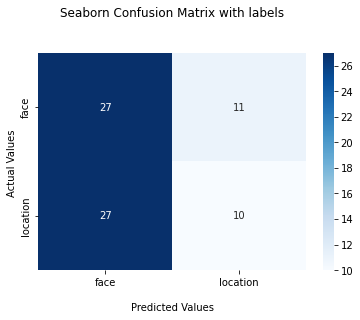

In [ ]:

class_weights = {0:1, 1:1}


checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                            save_best_only=True)


if 1:
  model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])

  fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 20,
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer], class_weight = class_weights)
  model.load_weights('/tmp/checkpoint.h5')
  ytest, preds, accuracies_of_version = evaluate_model(model, X_test, Y_test, X_validate, Y_validate, X_train, Y_train)
  cf_matrix = generate_confusion_matrix(ytest, preds, class_names=['face', 'location'])



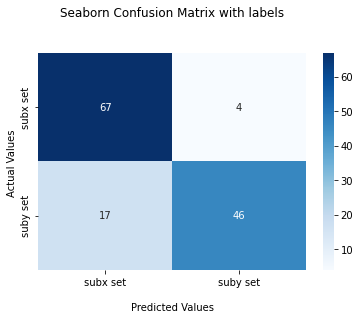

array([[67,  4],
       [17, 46]])

In [ ]:
ml_diff_verdict(subx=[1, 2], suby=[3, 4])

### **Visualisation of Standard Multi Dimensional Datasets**

In [ ]:
from sklearn.datasets import load_iris, load_digits, fetch_olivetti_faces, fetch_rcv1
import pandas as pd
data_iris = load_iris()  #dimensionality 4
data_digits = load_digits() #dimensionality 64
data_faces = fetch_olivetti_faces() #dimensionality 4096





/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.264372
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.071060
[t-SNE] KL divergence after 2900 iterations: 0.297031
10


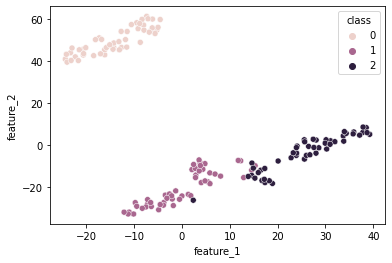

In [ ]:
from meg_pred_analysis import PCA, scatterplot, plt, perplexity_determiner, TSNE

X = data_iris['data']
Y_class = data_iris['target']
skip_pca = True
perp = 'auto'
hue_type = 'class'
iter = 5000

pca_result = X
if not(skip_pca):
  pca = PCA(n_components=min(X.shape[1],50))#n_components=min(X.shape[0], X.shape[1])
  pca_result = pca.fit_transform(X)

if perp == 'auto':
  perp = perplexity_determiner(Y_class)
tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=iter)
tsne_result = tsne.fit_transform(pca_result)
print(perp)
X = tsne_result
#Y = np.concatenate([data_irisx_label, data_irisy_label], axis=0)

dataset_iris = pd.DataFrame({'feature_1':X[:,0], 'feature_2':X[:,1], 'class':Y_class})

fig, ax = plt.subplots()
#ax.set_ylim(-20,100)
scatterplot(x="feature_1", y= "feature_2", data=dataset_iris, hue=hue_type, ax=ax)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.001s...
[t-SNE] Computed neighbors for 1797 samples in 0.185s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 3.779483
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.569351
[t-SNE] KL divergence after 5000 iterations: 0.684858
2


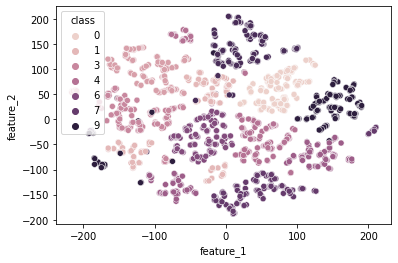

In [ ]:
from meg_pred_analysis import PCA, scatterplot, plt, perplexity_determiner, TSNE

X = data_digits['data']
Y_class = data_digits['target']
skip_pca = False
perp = 2 #'auto'
hue_type = 'class'
iter = 5000

pca_result = X
if not(skip_pca):
  pca = PCA(n_components=min(X.shape[1],50))#n_components=min(X.shape[0], X.shape[1])
  pca_result = pca.fit_transform(X)

if perp == 'auto':
  perp = perplexity_determiner(Y_class)
tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=iter)
tsne_result = tsne.fit_transform(pca_result)
print(perp)
X = tsne_result
#Y = np.concatenate([data_digitsx_label, data_digitsy_label], axis=0)

dataset_digits = pd.DataFrame({'feature_1':X[:,0], 'feature_2':X[:,1], 'class':Y_class})

fig, ax = plt.subplots()
#ax.set_ylim(-20,100)
scatterplot(x="feature_1", y= "feature_2", data=dataset_digits, hue=hue_type, ax=ax)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 52 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 3.573189
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.692337
[t-SNE] KL divergence after 3250 iterations: 0.629266


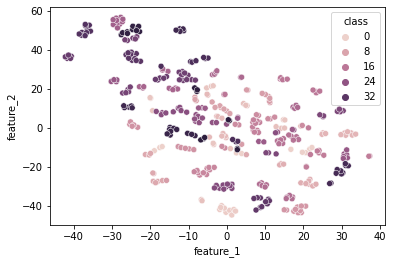

In [ ]:
from meg_pred_analysis import PCA, scatterplot, plt, perplexity_determiner, TSNE

X = data_faces['data']
Y_class = data_faces['target']
skip_pca = False #False
perp = 'auto'
hue_type = 'class'
iter = 5000

pca_result = X
if not(skip_pca):
  pca = PCA(n_components=min(X.shape[1],50))#n_components=min(X.shape[0], X.shape[1])
  pca_result = pca.fit_transform(X)

if perp == 'auto':
  perp = perplexity_determiner(Y_class)
tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=iter)
tsne_result = tsne.fit_transform(pca_result)

X = tsne_result
#Y = np.concatenate([data_facesx_label, data_facesy_label], axis=0)

dataset_digits = pd.DataFrame({'feature_1':X[:,0], 'feature_2':X[:,1], 'class':Y_class})

fig, ax = plt.subplots()
#ax.set_ylim(-20,100)
scatterplot(x="feature_1", y= "feature_2", data=dataset_digits, hue=hue_type, ax=ax)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 140 samples in 0.000s...
[t-SNE] Computed neighbors for 140 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 140 / 140
[t-SNE] Mean sigma: 10.714361
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.033981
[t-SNE] KL divergence after 1500 iterations: 1.419943


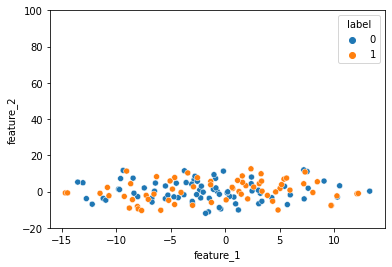

In [ ]:
meg_pred_analysis.SAVE_DATAX = {'stored':None}
meg_pred_analysis.SAVE_DATAY = {'stored':None}
tsne_visualise(subx=[1,2], suby=[3,4], hue_type='label', style_type=None, perp='auto', iter=5000, focus_on='test') #label is marking on subx, suby while class is marking on Y classification values

In [ ]:
#meg_pred_analysis.perplexity_determiner(labels) #determining perplexity according to the power law stated in the article : https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868#:~:text=The%20optimal%20perplexity%20can%20be%20calculated%20from%20the%20number%20of,data%20points%20of%20~100%20units
